# Error Analysis on the Classification Results

In [1]:
import pandas as pd
import numpy as np
import os
import re
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from helpersParsingResults import parse_ground_truth_and_predictions, import_HIPE_results

In [2]:
PRED_DIR = "./../data/results/"
TRUE_DIR = "./../data/release/2/"

TRUE_FILES = {"de": {"dev": "de/newsagency-data-2-dev-de.tsv", 
                     "test": "de/newsagency-data-2-test-de.tsv"},
              "fr": {"dev": "fr/newsagency-data-2-dev-fr.tsv", 
                     "test": "fr/newsagency-data-2-test-fr.tsv"}
}

PRED_FILES = {
    "de": {"dev": "newsagency-data-2-dev-de_pred.tsv", 
           "test": "newsagency-data-2-test-de_pred.tsv"},
    "fr": {"dev": "newsagency-data-2-dev-fr_pred.tsv", 
           "test": "newsagency-data-2-test-fr_pred.tsv"}
}

## Parse Prediction and Ground Truth File

In [3]:
def parse_tsv_gt_and_prediction(model_dir: str, set="dev", lang="de"):
    #get ground truth
    true_file = os.path.join(TRUE_DIR, TRUE_FILES[lang][set])
    with open(true_file, "r") as f:
        true_lines = [line for line in f]

    #get predictions
    pred_file = os.path.join(PRED_DIR, model_dir, PRED_FILES[lang][set])
    with open(pred_file, "r") as f:
        pred_lines = [line for line in f]

    return parse_ground_truth_and_predictions(pred_lines, true_lines)

In [4]:
imported_models = {
    "bert_64_de_dev": parse_tsv_gt_and_prediction("model_bert_base_german_cased_max_sequence_length_64_epochs_3_run_de_1", "dev", "de"),
    "bert_64_de_test": parse_tsv_gt_and_prediction("model_bert_base_german_cased_max_sequence_length_64_epochs_3_run_de_1", "test", "de"),
    "europeana_64_fr_dev": parse_tsv_gt_and_prediction("model_dbmdz_bert_base_french_europeana_cased_max_sequence_length_64_epochs_3_run_fr_1", "dev", "fr"),
    "europeana_64_fr_test": parse_tsv_gt_and_prediction("model_dbmdz_bert_base_french_europeana_cased_max_sequence_length_64_epochs_3_run_fr_1", "test", "fr")
}
imported_models["bert_64_de_dev"].head(10)

,token,pred_ag,true_ag,pos_in_doc,len_doc,LED,is_correct_class,at_beginning,at_end,in_middle
0,Exchange,Extel,Extel,131.0,303.0,0.0,True,False,False,True
1,United,UP-UPI,UP-UPI,211.0,303.0,0.0,True,False,False,True
2,Preß,UP-UPI,UP-UPI,212.0,303.0,0.0,True,False,False,True
0,Reuter,Reuters,Reuters,36.0,671.0,0.0,True,False,False,True
1,Reuter,Reuters,Reuters,425.0,671.0,0.0,True,False,False,True
2,AFP,AFP,AFP,521.0,671.0,0.0,True,False,False,True
3,AFP,AFP,AFP,620.0,671.0,0.0,True,False,False,True
0,United,UP-UPI,UP-UPI,511.0,747.0,0.0,True,False,False,True
1,Press,UP-UPI,UP-UPI,512.0,747.0,0.0,True,False,False,True
0,ag,ag,ag,7.0,287.0,0.0,True,True,False,False


## Confusion Matrix

In [5]:
def plot_confusion_matrix(df, title, make_plot=False, ax=None):
    labels = list(set(list(df["true_ag"]) + list(df["pred_ag"])))
    labels = [entry for entry in labels if not entry == "O"] + ["O"]
    cf_matrix = confusion_matrix(df["true_ag"], df["pred_ag"], labels=labels)

    #plotting
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))
    s = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, ax=ax, cmap="rocket_r")
    s.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(title)

    if make_plot:
        plt.show()

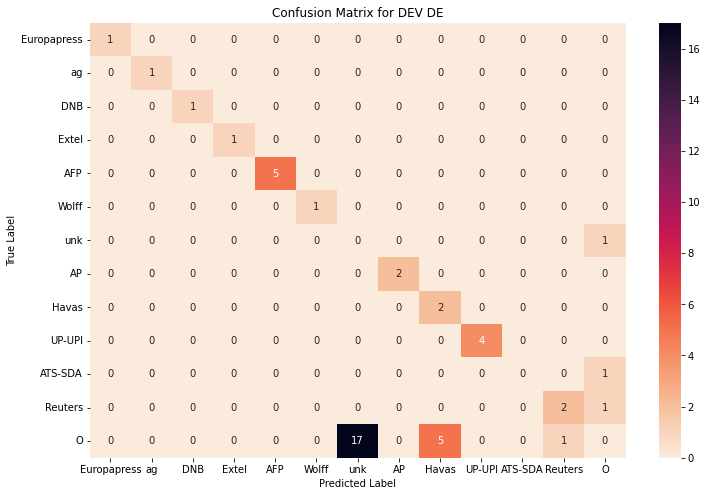

In [6]:
plot_confusion_matrix(imported_models["bert_64_de_dev"], "Confusion Matrix for DEV DE")

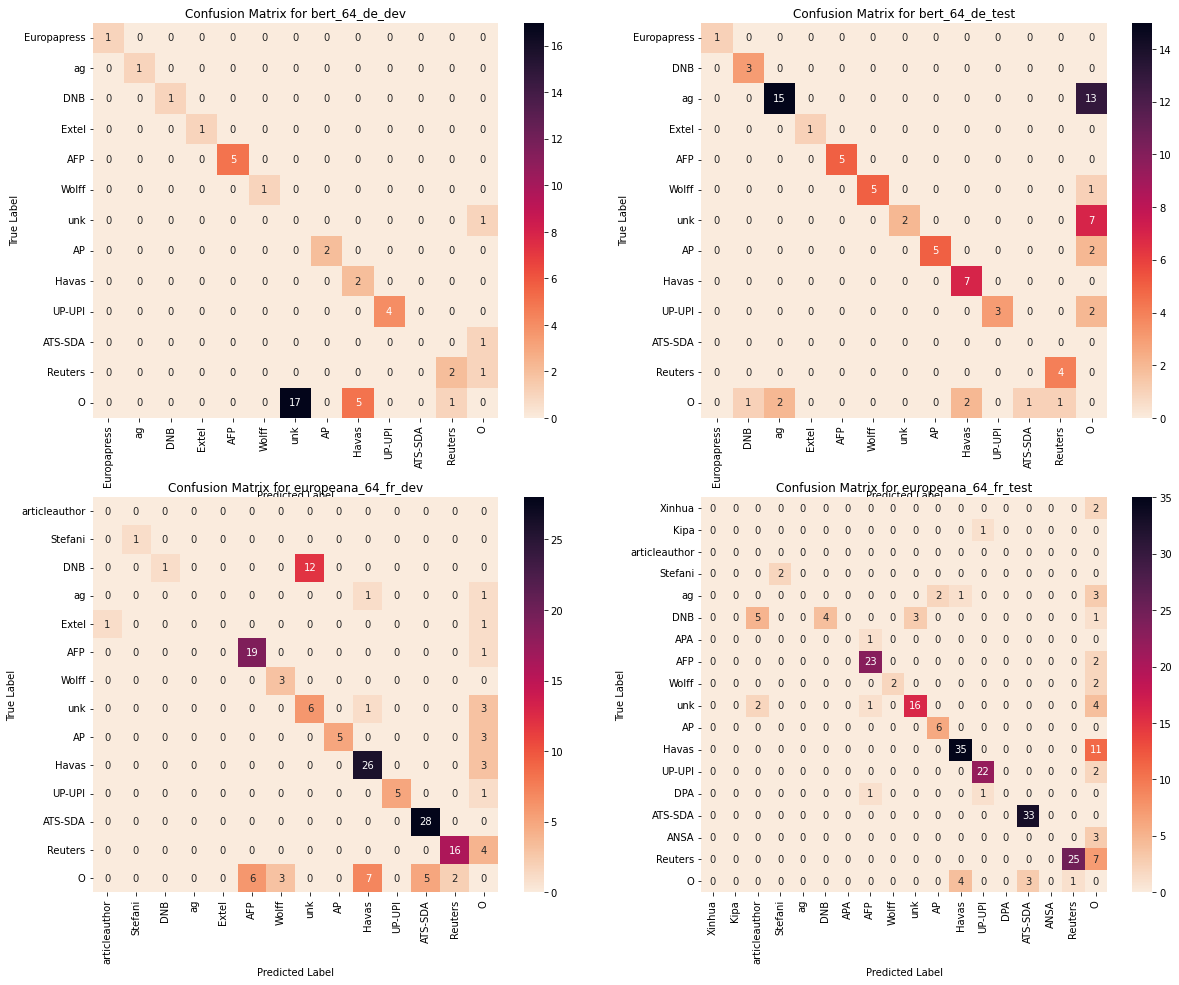

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for (i,j), model in zip([(0,0), (0,1), (1,0), (1,1)], list(imported_models.keys())[:4]):
    plot_confusion_matrix(imported_models[model], f"Confusion Matrix for {model}", ax=axs[i,j])

## Positions of Agencies

In [8]:
def get_correct_ratio_per_pos(df, pos="at_beginning"):
   df_all = df[(df["pred_ag"] != "O") & 
               df[pos] ]
   df_correct = df_all[df_all["is_correct_class"]]
   # avoid division by 0
   if len(df_all) == 0:
      return None
   else:
      return round(len(df_correct)/len(df_all)*100, 2)

def get_correct_ratios(df):
   percs = {}
   percs["at_beginning"] = get_correct_ratio_per_pos(df, "at_beginning")
   percs["in_middle"] = get_correct_ratio_per_pos(df, "in_middle")
   percs["at_end"] = get_correct_ratio_per_pos(df, "at_end")
   return percs

In [9]:
for model, model_df in imported_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratios(model_df)}\n")

bert_64_de_dev - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 42.5, 'at_end': 100.0}

bert_64_de_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 87.27, 'at_end': None}

europeana_64_fr_dev - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 69.67, 'at_end': 93.33}

europeana_64_fr_test - % of correctly predicted news agencies:
{'at_beginning': 100.0, 'in_middle': 83.23, 'at_end': 100.0}



## OCR Noise

In [10]:
def get_correct_ratio_per_noise(df):
    df_equal_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] == 0 ]
    df_bigger_0 = df[(df["pred_ag"] != "O") & 
               df["LED"] > 0 ]
    df_equal_0_correct = df_equal_0[df_equal_0["is_correct_class"]]
    df_bigger_0_correct = df_bigger_0[df_bigger_0["is_correct_class"]]

    len_equal = len(df_equal_0)
    len_bigger = len(df_bigger_0)

    return {
        "LED == 0": (round(len(df_equal_0_correct)/len_equal *100, 2), len_equal) if len_equal > 0 else None,
        "LED > 0": (round(len(df_bigger_0_correct)/len_bigger *100, 2), len_bigger) if len_bigger > 0 else None,
    }

In [11]:
for model, model_df in imported_models.items():
    print(f"{model} - % of correctly predicted news agencies:\n{get_correct_ratio_per_noise(model_df)}\n")

bert_64_de_dev - % of correctly predicted news agencies:
{'LED == 0': (43.48, 46), 'LED > 0': None}

bert_64_de_test - % of correctly predicted news agencies:
{'LED == 0': (60.98, 82), 'LED > 0': (100.0, 1)}

europeana_64_fr_dev - % of correctly predicted news agencies:
{'LED == 0': (66.67, 162), 'LED > 0': (66.67, 3)}

europeana_64_fr_test - % of correctly predicted news agencies:
{'LED == 0': (71.88, 224), 'LED > 0': (100.0, 7)}



#### HIPE Data

In [12]:
NOISE_LEVELS = ["LED-0.0-0.0", "LED-0.001-0.1", "LED-0.1-0.3", "LED-0.3-1.1"]
TIME_LEVELS = ["TIME-1800-1900", "TIME-1900-1940", "TIME-1940-2000"]

In [21]:
noise_dev_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir="../data/results/")
grouped_noise_dev_HIPE = noise_dev_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_dev_HIPE.head()

model language max_sequence_length    noise_level   run  \
                                                               count   
0  bert_base_cased       de                  64    LED-0.0-0.0     5   
1  bert_base_cased       de                  64  LED-0.001-0.1     5   
2  bert_base_cased       de                  64    LED-0.1-0.3     5   
3  bert_base_cased       de                  64    LED-0.3-1.1     5   
4  bert_base_cased       de                 128    LED-0.0-0.0     5   

   F1_micro           F1_macro_doc            TP  FN  
       mean       std         mean       std sum sum  
0  0.715568  0.067859     0.928593  0.037733  70  20  
1  0.000000  0.000000          NaN       NaN   0   0  
2  0.000000  0.000000          NaN       NaN   0   5  
3  0.177778  0.205631     1.000000  0.000000   3   2  
4  0.747895  0.031765     0.934074  0.019059  74  16

In [20]:
noise_test_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"], results_dir="../data/results/", set="test")
grouped_noise_test_HIPE = noise_test_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_test_HIPE.head()

model language max_sequence_length    noise_level   run  \
                                                               count   
0  bert_base_cased       de                  64    LED-0.0-0.0     5   
1  bert_base_cased       de                  64  LED-0.001-0.1     5   
2  bert_base_cased       de                  64    LED-0.1-0.3     5   
3  bert_base_cased       de                  64    LED-0.3-1.1     5   
4  bert_base_cased       de                 128    LED-0.0-0.0     5   

   F1_micro           F1_macro_doc             TP  FN  
       mean       std         mean       std  sum sum  
0  0.771530  0.024876     0.874163  0.019055  199  66  
1  0.000000  0.000000          NaN       NaN    0   0  
2  0.174103  0.044563     1.000000  0.000000    5   0  
3  0.000000  0.000000          NaN       NaN    0   0  
4  0.803855  0.030271     0.877540  0.014928  200  65